## ViT 실습

In [3]:
# 현재 작업 디렉토리(/content)에 fashion-mnist.zip이 있다고 하면
!unzip /content/drive/MyDrive/cbnu/datasets/13/fashionMNIST/fashion-mnist.zip -d /content/drive/MyDrive/cbnu/datasets/13/fashionMNIST

Archive:  /content/drive/MyDrive/cbnu/datasets/13/fashionMNIST/fashion-mnist.zip
  inflating: /content/drive/MyDrive/cbnu/datasets/13/fashionMNIST/fashion-mnist_test.csv  
  inflating: /content/drive/MyDrive/cbnu/datasets/13/fashionMNIST/fashion-mnist_train.csv  
  inflating: /content/drive/MyDrive/cbnu/datasets/13/fashionMNIST/t10k-images-idx3-ubyte  
  inflating: /content/drive/MyDrive/cbnu/datasets/13/fashionMNIST/t10k-labels-idx1-ubyte  
  inflating: /content/drive/MyDrive/cbnu/datasets/13/fashionMNIST/train-images-idx3-ubyte  
  inflating: /content/drive/MyDrive/cbnu/datasets/13/fashionMNIST/train-labels-idx1-ubyte  


In [5]:
!pip install "sentence-transformers<2.2.0" transformers==4.36.0 peft==0.10.0 accelerate==0.28.0 evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=120986 sha256=4df474d073e7c5fada9b124e264d17ee10204b243b30a3645c511eeaefa44ecc
  Stored in directory: /root/.cache/pip/wheels/92/0b/6e/ec5828f0fbec99d77e3ba27f7b27a895153b25a1576bf69fd0
Successfully built sentence-transformers
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 4.1.0
    Uninstalling sentence-transformers-4.1.0:
      Successfully uninstalled sentence-transformers-4.1.0


In [7]:
!pip uninstall -y jax jaxlib
!pip install --upgrade jax jaxlib

Found existing installation: jax 0.5.2
Uninstalling jax-0.5.2:
  Successfully uninstalled jax-0.5.2
Found existing installation: jaxlib 0.5.1
Uninstalling jaxlib-0.5.1:
  Successfully uninstalled jaxlib-0.5.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 49.8 MB/s eta 0:00:00
  Attempting uninstall: ml_dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires ml-dtypes<0.5.0,>=0.4.0, but you have ml-dtypes 0.5.1 which is incompatible.


In [2]:
import torch
import evaluate
import numpy as np
from itertools import chain
from collections import defaultdict
from torch.utils.data import Subset
from torchvision import datasets
from torchvision import transforms
from transformers import AutoImageProcessor
from transformers import ViTForImageClassification
from transformers import TrainingArguments, Trainer


def subset_sampler(dataset, classes, max_len):
    target_idx = defaultdict(list)
    for idx, label in enumerate(dataset.train_labels):
        target_idx[int(label)].append(idx)

    indices = list(
        chain.from_iterable(
            [target_idx[idx][:max_len] for idx in range(len(classes))]
        )
    )
    return Subset(dataset, indices)


def model_init(classes, class_to_idx):
    model = ViTForImageClassification.from_pretrained(
        "google/vit-base-patch16-224-in21k",
        num_labels=len(classes),
        id2label={idx: label for label, idx in class_to_idx.items()},
        label2id=class_to_idx,
    )
    return model


def collator(data, transform):
    images, labels = zip(*data)
    pixel_values = torch.stack([transform(image) for image in images])
    labels = torch.tensor([label for label in labels])
    return {"pixel_values": pixel_values, "labels": labels}


def compute_metrics(eval_pred):
    metric = evaluate.load("f1")
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    macro_f1 = metric.compute(
        predictions=predictions, references=labels, average="macro"
    )
    return macro_f1


train_dataset = datasets.FashionMNIST(root="/content/drive/MyDrive/cbnu/datasets/13/fashionMNIST", download=True, train=True)
test_dataset = datasets.FashionMNIST(root="/content/drive/MyDrive/cbnu/datasets/13/fashionMNIST", download=True, train=False)

classes = train_dataset.classes
class_to_idx = train_dataset.class_to_idx

subset_train_dataset = subset_sampler(
    dataset=train_dataset, classes=train_dataset.classes, max_len=1000
)
subset_test_dataset = subset_sampler(
    dataset=test_dataset, classes=test_dataset.classes, max_len=100
)

image_processor = AutoImageProcessor.from_pretrained(
    "google/vit-base-patch16-224-in21k"
)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(
            size=(
                image_processor.size["height"],
                image_processor.size["width"]
            )
        ),
        transforms.Lambda(
            lambda x: torch.cat([x, x, x], 0)
        ),
        transforms.Normalize(
            mean=image_processor.image_mean,
            std=image_processor.image_std
        )
    ]
)

args = TrainingArguments(
    output_dir="/content/drive/MyDrive/cbnu/results/13/ViT-FashionMNIST",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.001,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="logs",
    logging_steps=125,
    remove_unused_columns=False,
    seed=7
)

trainer = Trainer(
    model_init=lambda x: model_init(classes, class_to_idx),
    args=args,
    train_dataset=subset_train_dataset,
    eval_dataset=subset_test_dataset,
    data_collator=lambda x: collator(x, transform),
    compute_metrics=compute_metrics,
    tokenizer=image_processor,
)
trainer.train()

/usr/local/lib/python3.11/dist-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yam-h29 (yam-h29-chungbuk-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,F1
1,0.694200,0.650120,0.868556
2,0.474200,0.468879,0.920344
3,0.407900,0.423378,0.924144


TrainOutput(global_step=1875, training_loss=0.6999690856933594, metrics={'train_runtime': 1214.8204, 'train_samples_per_second': 24.695, 'train_steps_per_second': 1.543, 'total_flos': 2.32492637712384e+18, 'train_loss': 0.6999690856933594, 'epoch': 3.0})

PredictionOutput(predictions=array([[ 3.0834806 , -0.55194736, -0.362603  , ..., -0.4709341 ,
        -0.3262713 , -0.6307243 ],
       [ 1.9406886 , -0.72545254, -0.31558412, ..., -0.7155954 ,
        -0.7546688 , -0.78376085],
       [ 2.9815443 , -0.52144015, -0.14134248, ..., -0.5305125 ,
        -0.3384841 , -0.6605314 ],
       ...,
       [-0.5470459 , -0.6828024 , -0.64727265, ...,  0.9893233 ,
         0.47116795,  2.6565032 ],
       [-0.6166747 , -0.4020607 , -0.3338782 , ...,  0.28243798,
        -0.28316966,  3.388763  ],
       [-0.48705873, -0.36253622, -0.28010324, ..., -0.20520988,
        -0.21008518,  3.4035861 ]], dtype=float32), label_ids=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

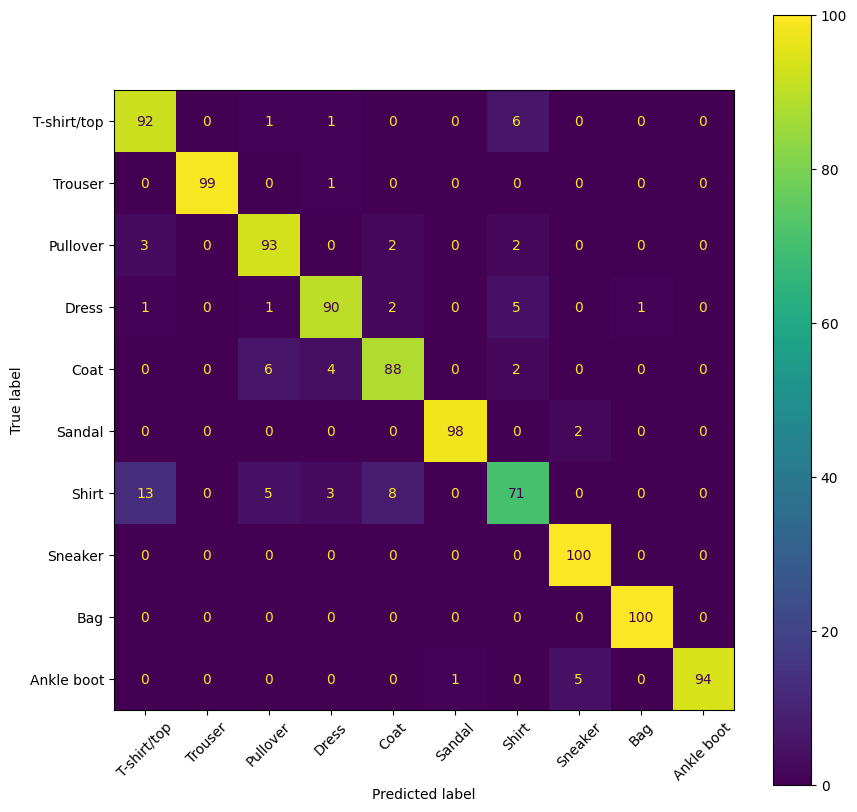

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


outputs = trainer.predict(subset_test_dataset)
print(outputs)

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = list(classes)
matrix = confusion_matrix(y_true, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=labels)
_, ax = plt.subplots(figsize=(10, 10))
display.plot(xticks_rotation=45, ax=ax)
plt.show()

## Swin Transformer 실습 (생략)
학습이 제대로 안되는데 모델이 이상한 듯

In [4]:
!pip install evaluate peft==0.10.0 transformers==4.36.0 accelerate==0.28.0

In [5]:
import torch
import evaluate
import numpy as np
from itertools import chain
from collections import defaultdict
from torch.utils.data import Subset
from torchvision import datasets
from torchvision import transforms
from transformers import AutoImageProcessor
from transformers import SwinForImageClassification
from transformers import TrainingArguments, Trainer


def subset_sampler(dataset, classes, max_len):
    target_idx = defaultdict(list)
    for idx, label in enumerate(dataset.train_labels):
        target_idx[int(label)].append(idx)

    indices = list(
        chain.from_iterable(
            [target_idx[idx][:max_len] for idx in range(len(classes))]
        )
    )
    return Subset(dataset, indices)


def model_init(classes, class_to_idx):
    model = SwinForImageClassification.from_pretrained(
        pretrained_model_name_or_path="microsoft/swin-tiny-patch4-window7-224",
        num_labels=len(classes),
        id2label={idx: label for label, idx in class_to_idx.items()},
        label2id=class_to_idx,
        ignore_mismatched_sizes=True
    )
    return model


def collator(data, transform):
    images, labels = zip(*data)
    pixel_values = torch.stack([transform(image) for image in images])
    labels = torch.tensor([label for label in labels])
    return {"pixel_values": pixel_values, "labels": labels}


def compute_metrics(eval_pred):
    metric = evaluate.load("f1")
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    macro_f1 = metric.compute(
        predictions=predictions, references=labels, average="macro"
    )
    return macro_f1


train_dataset = datasets.FashionMNIST(root="/content/drive/MyDrive/cbnu/datasets/13/fashionMNIST", download=True, train=True)
test_dataset = datasets.FashionMNIST(root="/content/drive/MyDrive/cbnu/datasets/13/fashionMNIST", download=True, train=False)

classes = train_dataset.classes
class_to_idx = train_dataset.class_to_idx

subset_train_dataset = subset_sampler(
    dataset=train_dataset, classes=train_dataset.classes, max_len=1000
)
subset_test_dataset = subset_sampler(
    dataset=test_dataset, classes=test_dataset.classes, max_len=100
)

image_processor = AutoImageProcessor.from_pretrained(
    pretrained_model_name_or_path="microsoft/swin-tiny-patch4-window7-224"
)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(
            size=(
                image_processor.size["height"],
                image_processor.size["width"]
            )
        ),
        transforms.Lambda(
            lambda x: torch.cat([x, x, x], 0)
        ),
        transforms.Normalize(
            mean=image_processor.image_mean,
            std=image_processor.image_std
        )
    ]
)

args = TrainingArguments(
    output_dir="/content/drive/MyDrive/cbnu/results/13/Swin-FashionMNIST",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.001,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="logs",
    logging_steps=125,
    remove_unused_columns=False,
    seed=7
)

trainer = Trainer(
    model_init=lambda x: model_init(classes, class_to_idx),
    args=args,
    train_dataset=subset_train_dataset,
    eval_dataset=subset_test_dataset,
    data_collator=lambda x: collator(x, transform),
    compute_metrics=compute_metrics,
    tokenizer=image_processor,
)
trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.11/dist-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably T

Epoch,Training Loss,Validation Loss,F1
1,65069740735188595619934502912.000000,64746015108117236441669435392.000000,0.018182
2,64997795141811686853002133504.000000,64746015108117236441669435392.000000,0.018182
3,65321559983414326395463008256.000000,64746015108117236441669435392.000000,0.018182


TrainOutput(global_step=1875, training_loss=6.474601683587372e+28, metrics={'train_runtime': 449.5152, 'train_samples_per_second': 66.739, 'train_steps_per_second': 4.171, 'total_flos': 7.4584635826176e+17, 'train_loss': 6.474601683587372e+28, 'epoch': 3.0})

## CvT 실습

In [ ]:
!pip install "sentence-transformers<2.2.0" transformers==4.36.0 peft==0.10.0 accelerate==0.28.0 evaluate # ViT에서 했으면 생략

In [9]:
import torch
import evaluate
import numpy as np
from itertools import chain
from collections import defaultdict
from torch.utils.data import Subset
from torchvision import datasets
from torchvision import transforms
from transformers import AutoImageProcessor
from transformers import CvtForImageClassification
from transformers import TrainingArguments, Trainer


def subset_sampler(dataset, classes, max_len):
    target_idx = defaultdict(list)
    for idx, label in enumerate(dataset.train_labels):
        target_idx[int(label)].append(idx)

    indices = list(
        chain.from_iterable(
            [target_idx[idx][:max_len] for idx in range(len(classes))]
        )
    )
    return Subset(dataset, indices)


def model_init(classes, class_to_idx):
    model = CvtForImageClassification.from_pretrained(
        pretrained_model_name_or_path="microsoft/cvt-21",
        num_labels=len(classes),
        id2label={idx: label for label, idx in class_to_idx.items()},
        label2id=class_to_idx,
        ignore_mismatched_sizes=True
    )
    return model


def collator(data, transform):
    images, labels = zip(*data)
    pixel_values = torch.stack([transform(image) for image in images])
    labels = torch.tensor([label for label in labels])
    return {"pixel_values": pixel_values, "labels": labels}


def compute_metrics(eval_pred):
    metric = evaluate.load("f1")
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    macro_f1 = metric.compute(
        predictions=predictions, references=labels, average="macro"
    )
    return macro_f1


train_dataset = datasets.FashionMNIST(root="/content/drive/MyDrive/cbnu/datasets/13/fashionMNIST", download=True, train=True)
test_dataset = datasets.FashionMNIST(root="/content/drive/MyDrive/cbnu/datasets/13/fashionMNIST", download=True, train=False)

classes = train_dataset.classes
class_to_idx = train_dataset.class_to_idx

subset_train_dataset = subset_sampler(
    dataset=train_dataset, classes=train_dataset.classes, max_len=1000
)
subset_test_dataset = subset_sampler(
    dataset=test_dataset, classes=test_dataset.classes, max_len=100
)

image_processor = AutoImageProcessor.from_pretrained(
    pretrained_model_name_or_path="microsoft/cvt-21"
)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(
            size=(
                image_processor.size["shortest_edge"],
                image_processor.size["shortest_edge"]
            )
        ),
        transforms.Lambda(
            lambda x: torch.cat([x, x, x], 0)
        ),
        transforms.Normalize(
            mean=image_processor.image_mean,
            std=image_processor.image_std
        )
    ]
)

args = TrainingArguments(
    output_dir="/content/drive/MyDrive/cbnu/results/13/CvT-FashionMNIST",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.001,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="logs",
    logging_steps=125,
    remove_unused_columns=False,
    seed=7
)

trainer = Trainer(
    model_init=lambda x: model_init(classes, class_to_idx),
    args=args,
    train_dataset=subset_train_dataset,
    eval_dataset=subset_test_dataset,
    data_collator=lambda x: collator(x, transform),
    compute_metrics=compute_metrics,
    tokenizer=image_processor,
)
trainer.train()

/usr/local/lib/python3.11/dist-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


config.json:   0%|          | 0.00/70.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/127M [00:00<?, ?B/s]

Some weights of CvtForImageClassification were not initialized from the model checkpoint at microsoft/cvt-21 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([10, 384]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of CvtForImageClassification were not initialized from the model checkpoint at microsoft/cvt-21 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([10, 384]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be ab

Epoch,Training Loss,Validation Loss,F1
1,0.826200,0.339159,0.892534
2,0.679100,0.277195,0.907703
3,0.655100,0.263874,0.916231


Checkpoint destination directory /content/drive/MyDrive/cbnu/results/13/CvT-FashionMNIST/checkpoint-625 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory /content/drive/MyDrive/cbnu/results/13/CvT-FashionMNIST/checkpoint-1250 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=1875, training_loss=0.7840469523111979, metrics={'train_runtime': 702.6697, 'train_samples_per_second': 42.694, 'train_steps_per_second': 2.668, 'total_flos': 8.4649093853184e+17, 'train_loss': 0.7840469523111979, 'epoch': 3.0})

PredictionOutput(predictions=array([[ 8.611191  , -1.6471304 ,  0.6278465 , ..., -3.2304466 ,
        -1.6793584 , -2.4104187 ],
       [ 4.656513  ,  0.03085495, -0.4150304 , ..., -3.1694455 ,
        -1.4019701 , -2.78706   ],
       [ 8.953199  , -3.0237923 ,  0.90923953, ..., -2.5933788 ,
        -0.590006  , -1.9843737 ],
       ...,
       [-0.95138574, -3.7349598 , -1.564448  , ...,  2.26339   ,
        -1.541862  ,  6.001469  ],
       [ 0.29058382, -2.4529226 , -2.1527581 , ...,  1.6964405 ,
        -2.9617584 ,  9.3743725 ],
       [-0.63357824, -1.2306345 , -2.2583492 , ...,  0.13297997,
        -3.2178776 ,  8.964937  ]], dtype=float32), label_ids=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

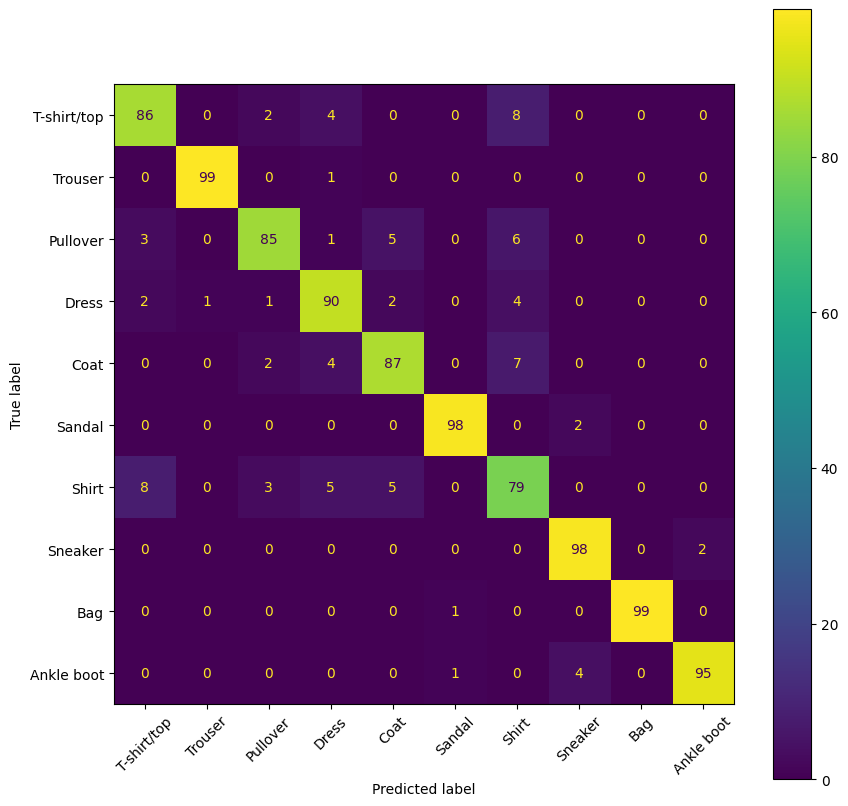

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


outputs = trainer.predict(subset_test_dataset)
print(outputs)

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = list(classes)
matrix = confusion_matrix(y_true, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=labels)
_, ax = plt.subplots(figsize=(10, 10))
display.plot(xticks_rotation=45, ax=ax)
plt.show()